author is derek martinez

In [1]:
import scanpy as sc 
import numpy as np
import pandas as pd  
import GEOparse as geo
from pathlib import Path

In [2]:
data_dir = Path("GSE184880_RAW")
for sample_dir in data_dir.iterdir():
    print(sample_dir)

GSE184880_RAW/Cancer_HGSOC2
GSE184880_RAW/Cancer_HGSOC5
GSE184880_RAW/.DS_Store
GSE184880_RAW/Cancer_HGSOC4
GSE184880_RAW/Cancer_HGSOC3
GSE184880_RAW/Normal ovarian tissue1
GSE184880_RAW/Cancer_HGSOC6
GSE184880_RAW/Cancer_HGSOC1
GSE184880_RAW/Cancer_HGSOC7
GSE184880_RAW/Normal ovarian tissue4
GSE184880_RAW/Normal ovarian tissue3
GSE184880_RAW/Normal ovarian tissue2
GSE184880_RAW/Normal ovarian tissue5


In [4]:
from pathlib import Path
import scanpy as sc

adata_list = []
for sample_dir in data_dir.iterdir():
    print(sample_dir)
    if sample_dir.is_dir():
        try:
            adata = sc.read_10x_mtx(sample_dir, var_names="gene_symbols")
            adata.obs["sample"] = sample_dir.name
            if sample_dir.name[:1] == 'C':
                adata.obs['group'] = 'Cancer'
            else:
                adata.obs['group'] = 'Normal'
            adata_list.append(adata)
        except EOFError as e:
            print(f"Error: Corrupted file in {sample_dir}. Skipping this sample.")
            print(e)
        except Exception as e:
            print(f"Error: {e} occurred for sample {sample_dir}. Skipping this sample.")

GSE184880_RAW/Cancer_HGSOC2
GSE184880_RAW/Cancer_HGSOC5
GSE184880_RAW/Cancer_HGSOC4
GSE184880_RAW/Cancer_HGSOC3
GSE184880_RAW/Normal ovarian tissue1
GSE184880_RAW/Cancer_HGSOC6
GSE184880_RAW/Cancer_HGSOC1
GSE184880_RAW/Cancer_HGSOC7
GSE184880_RAW/Normal ovarian tissue4
GSE184880_RAW/Normal ovarian tissue3
GSE184880_RAW/Normal ovarian tissue2
GSE184880_RAW/Normal ovarian tissue5


In [5]:
adata_combined = adata_list[0].concatenate(*adata_list[1:], batch_key="sample")

/var/folders/66/xf6391m10_1_0gt7tbm34_7r0000gn/T/ipykernel_3175/1545357242.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_combined = adata_list[0].concatenate(*adata_list[1:], batch_key="sample")


In [7]:
adata_t = adata_combined[(adata_combined[:,'CD3D'].X > 0)]

In [9]:
sc.pp.normalize_total(adata_t, inplace=True)

/usr/local/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [10]:
sc.pp.log1p(adata_t)

In [11]:
mean_expr = pd.Series(adata_t.X.mean(axis=0).A1 if hasattr(adata_t.X.mean(axis=0), 'A1') else adata_t.X.mean(axis=0).ravel())
mean_expr.index = adata_t.var.index
mean_expr.describe()

count    27984.000000
mean         0.053319
std          0.184330
min          0.000000
25%          0.000013
50%          0.001844
75%          0.039620
max          5.584604
dtype: float64

In [12]:
adata_t = adata_t[:, mean_expr[mean_expr >= 0.001844].index]

In [14]:
sc.tl.pca(adata_t)

/usr/local/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


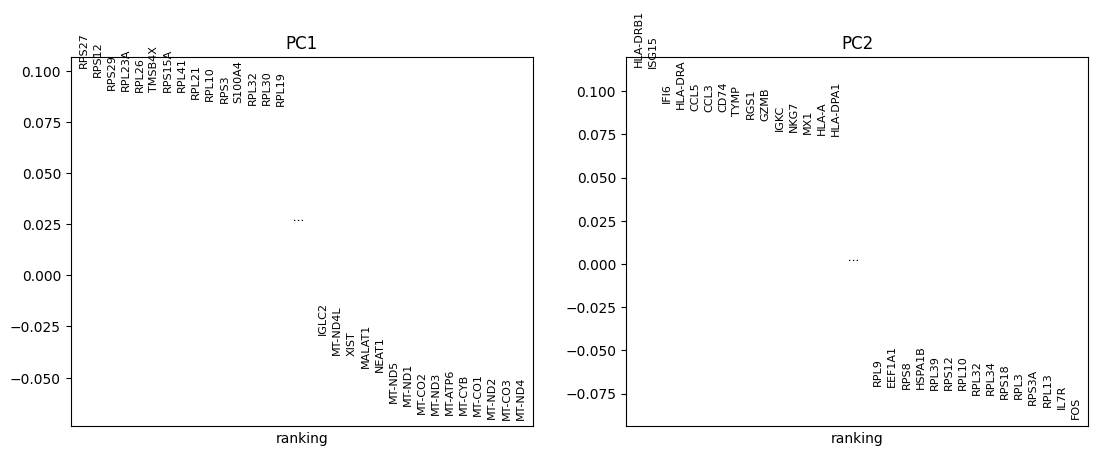

In [15]:
sc.pl.pca_loadings(adata_t, components = '1,2')

/var/folders/66/xf6391m10_1_0gt7tbm34_7r0000gn/T/ipykernel_3175/1709022566.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_t, resolution=0.3, flavor='leidenalg')


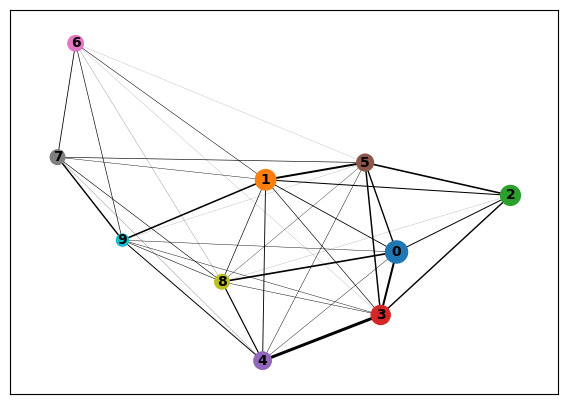

In [16]:
sc.pp.neighbors(adata_t, n_neighbors=15, n_pcs= 15, random_state=0)
sc.tl.leiden(adata_t, resolution=0.3, flavor='leidenalg')
sc.tl.paga(adata_t)
sc.pl.paga(adata_t)
sc.tl.umap(adata_t, init_pos='paga', random_state=0)

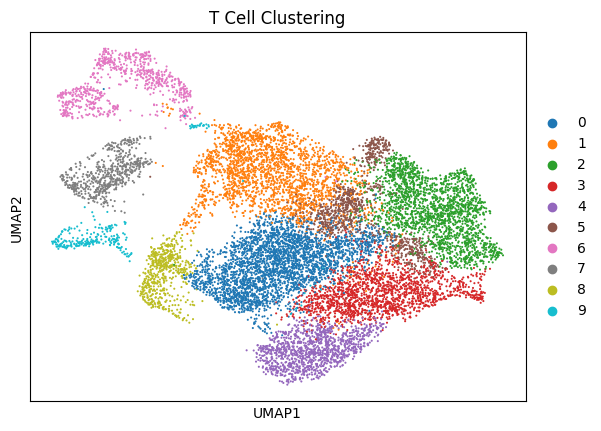

In [17]:
sc.pl.umap(adata_t, color= 'leiden', cmap='turbo', title = 'T Cell Clustering')

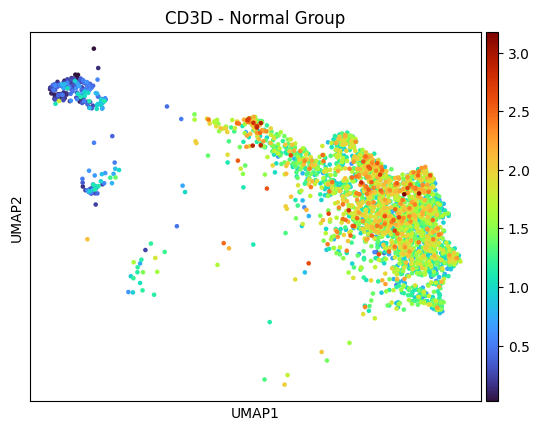

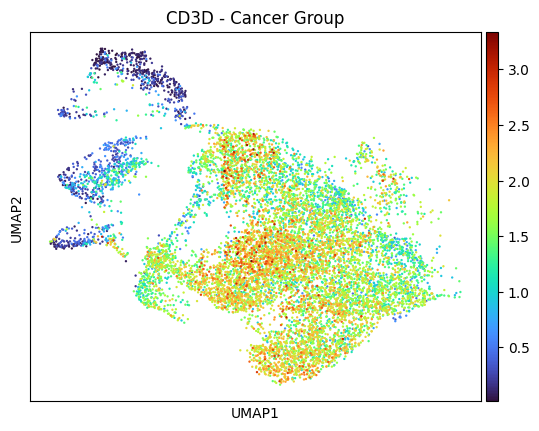

In [18]:
for group in ['Normal', "Cancer"]:
    adata_group = adata_t[adata_t.obs['group'] == group]
    
    sc.pl.umap(
    adata_group,
    color= 'CD3D',
    title=f'CD3D - {group} Group',
    cmap='turbo', # Show legends directly on the UMAP
    show=False             # Prevent immediate display
)

In [21]:
count_t = adata_t.obs['group'].value_counts()
count_all = adata_combined.obs['group'].value_counts()

t_percentage_healthy = count_t[1]/count_all[1]
t_percentage_SLE = count_t[0]/count_all[0]

print("T Cell percentage in normal group: {}".format(t_percentage_healthy))
print("T Cell percentage in cancer group: {}".format(t_percentage_SLE))

T Cell percentage in normal group: 0.1023109632094657
T Cell percentage in cancer group: 0.2703803997421019


/var/folders/66/xf6391m10_1_0gt7tbm34_7r0000gn/T/ipykernel_3175/604127431.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_percentage_healthy = count_t[1]/count_all[1]
/var/folders/66/xf6391m10_1_0gt7tbm34_7r0000gn/T/ipykernel_3175/604127431.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_percentage_SLE = count_t[0]/count_all[0]


group
Cancer    10484
Normal     2767
Name: count, dtype: int64


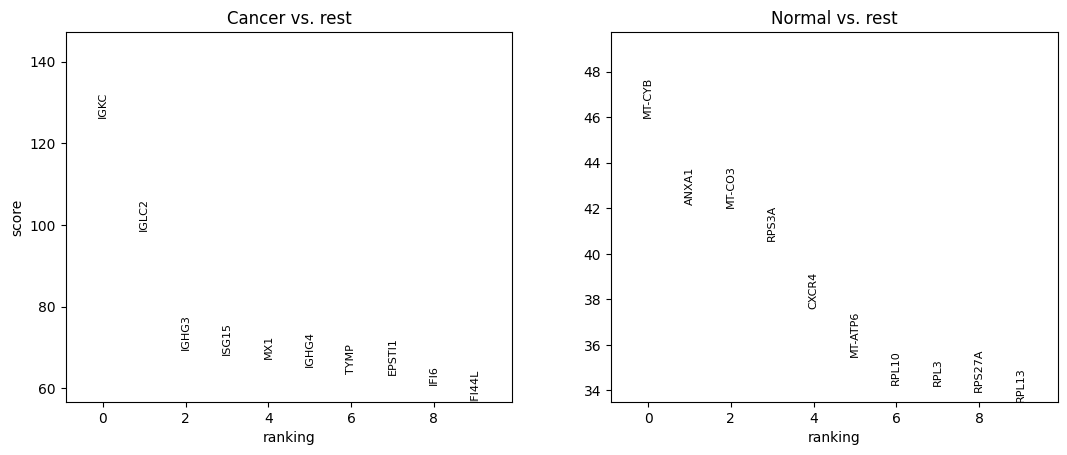

In [25]:
print(adata_t.obs['group'].value_counts())
sc.tl.rank_genes_groups(adata_t, groupby='group', method='t-test')
sc.pl.rank_genes_groups(adata_t, n_genes=10, sharey=False)

In [26]:
import pandas as pd

result = adata_t.uns['rank_genes_groups']
groups = result['names'].dtype.names

scores_df = pd.DataFrame(
    {group: result['scores'][group] for group in groups},
    index=result['names'][groups[0]]
)

print(scores_df.head())


           Cancer     Normal
IGKC   126.363922  45.990818
IGLC2   98.545738  42.161728
IGHG3   69.526909  42.027817
ISG15   68.203743  40.568623
MX1     67.270256  37.605820


In [27]:
markers = ['IGKC', 'IGLC2', 'IGHG3', 'ISG15', 'MT-CYB', 'ANXA1', 'MT-CO3', 'RPS3A']

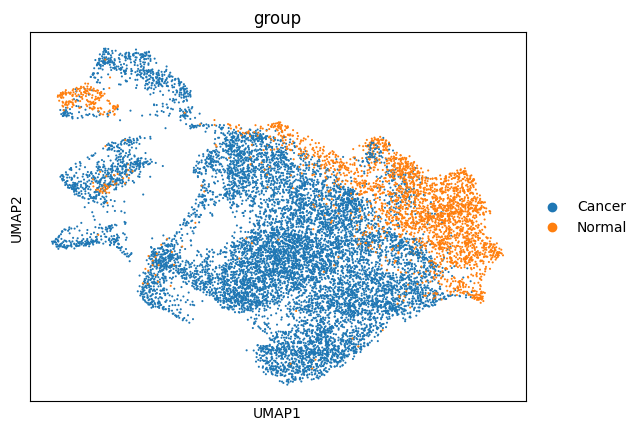

In [28]:
sc.pl.umap(adata_t, color= 'group', cmap='turbo')

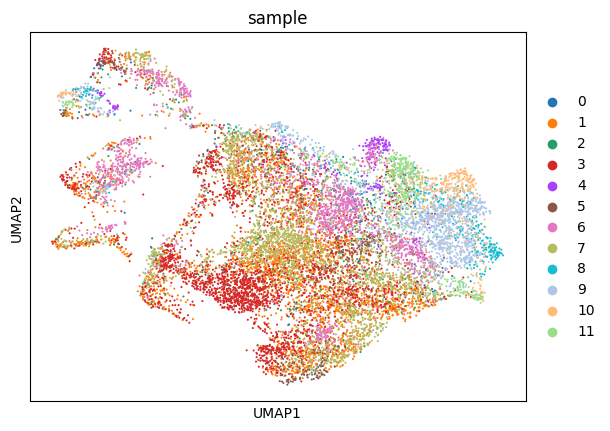

In [29]:
sc.pl.umap(adata_t, color= 'sample', cmap='turbo')

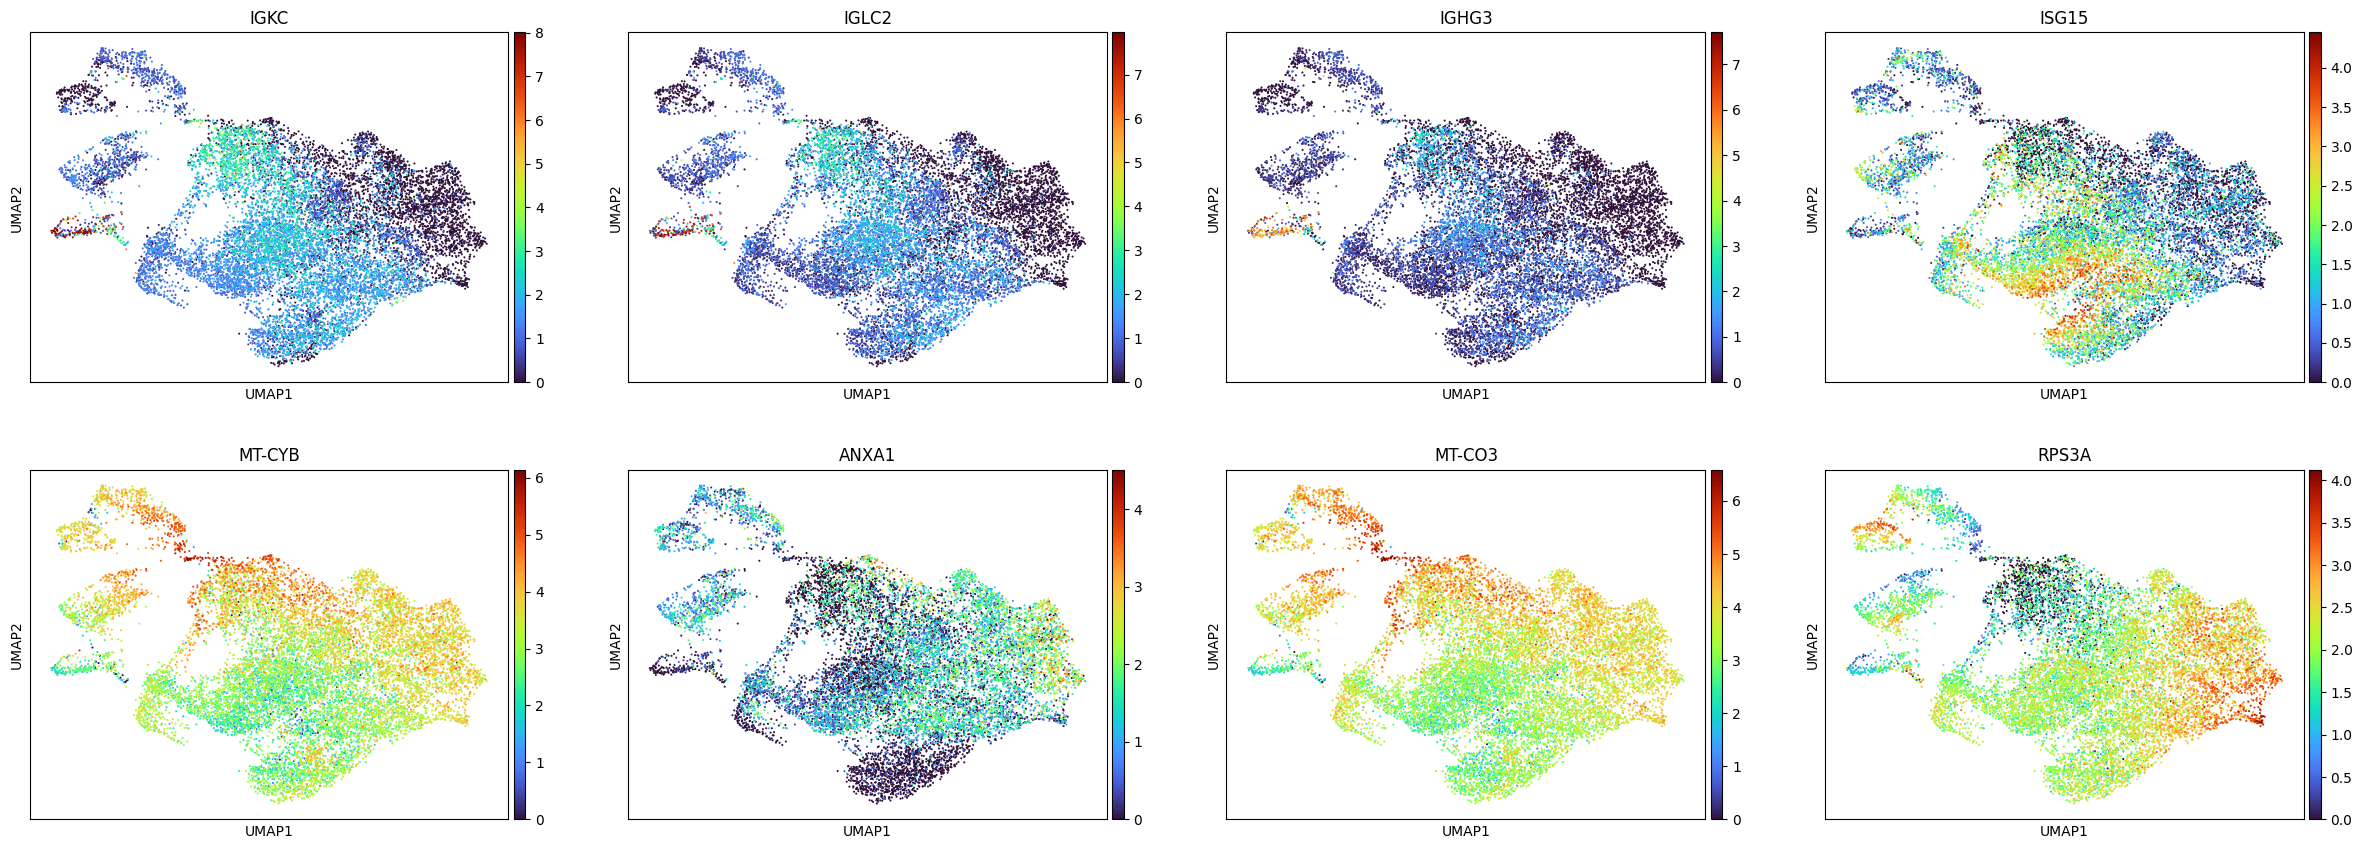

In [30]:
sc.pl.umap(adata_t, color= markers, cmap='turbo')

In [40]:
adata_b = adata_combined[(adata_combined[:,'CD19'].X > 0)]
sc.pp.normalize_total(adata_b, inplace=True)
sc.pp.log1p(adata_b)

/usr/local/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [41]:
mean_expr_b = pd.Series(adata_b.X.mean(axis=0).A1 if hasattr(adata_b.X.mean(axis=0), 'A1') else adata_b.X.mean(axis=0).ravel())
mean_expr_b.index = adata_b.var.index
mean_expr_b.describe()

count    27984.000000
mean         0.141658
std          0.330858
min          0.000000
25%          0.000000
50%          0.015042
75%          0.157626
max          6.476307
dtype: float64

In [42]:
sc.tl.pca(adata_b)

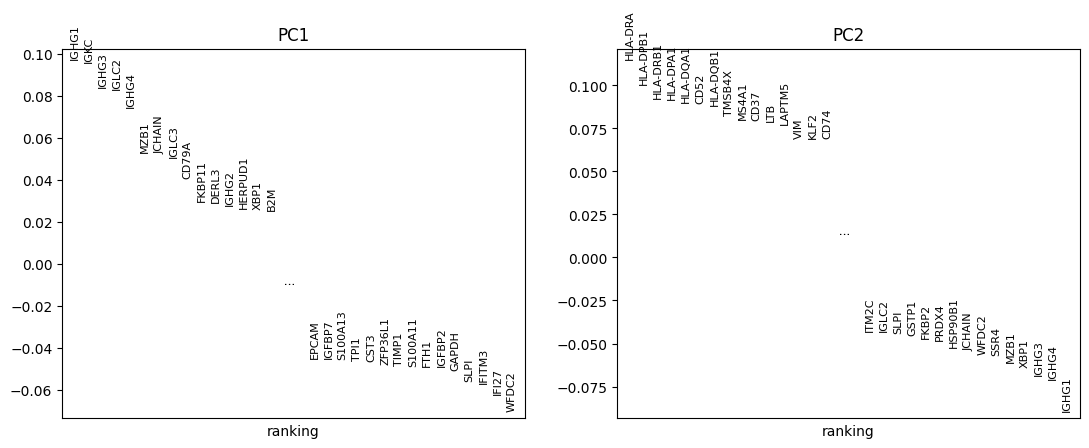

In [43]:
sc.pl.pca_loadings(adata_b, components = '1,2')

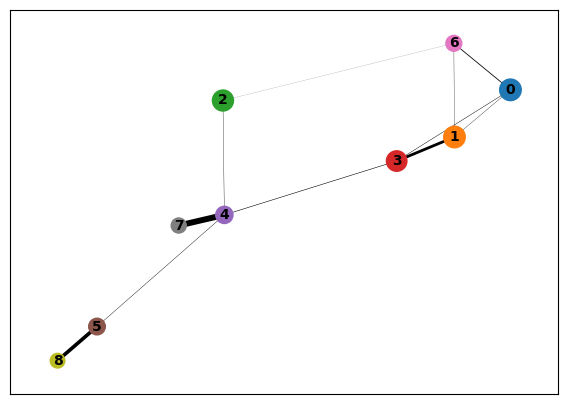

In [44]:
sc.pp.neighbors(adata_b, n_neighbors=15, n_pcs= 15, random_state=0)
sc.tl.leiden(adata_b, resolution=0.3, flavor='leidenalg')
sc.tl.paga(adata_b)
sc.pl.paga(adata_b)
sc.tl.umap(adata_b, init_pos='paga', random_state=0)

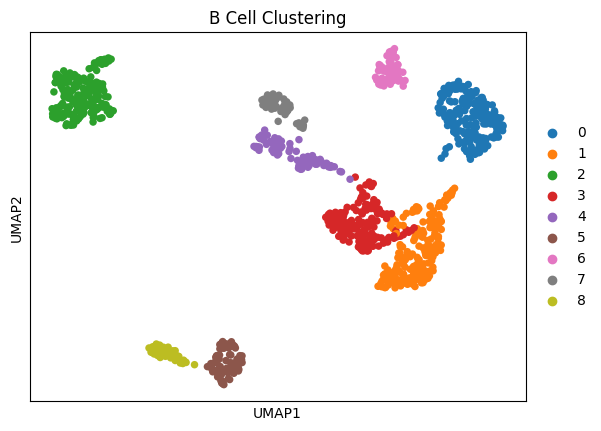

In [45]:
sc.pl.umap(adata_b, color= 'leiden', cmap='turbo', title = 'B Cell Clustering')

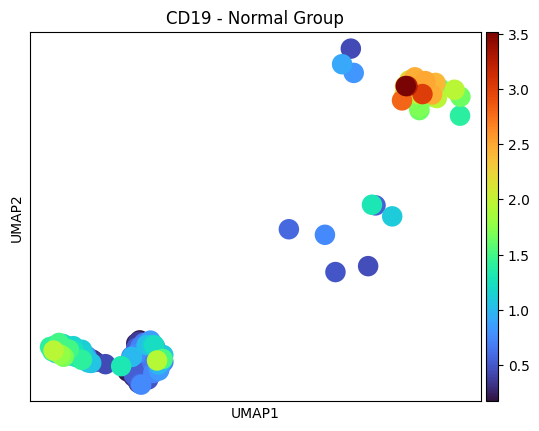

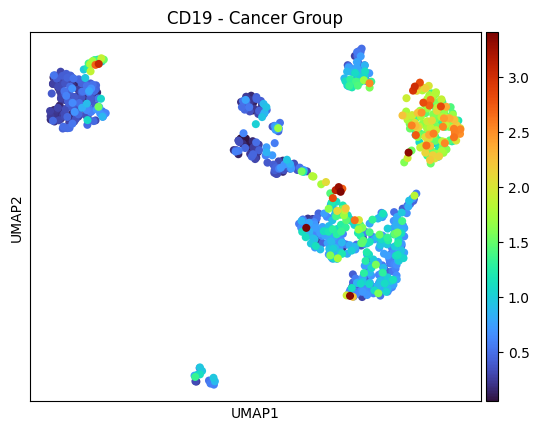

In [46]:
for group in ['Normal', "Cancer"]:
    adata_group = adata_b[adata_b.obs['group'] == group]
    
    sc.pl.umap(
    adata_group,
    color= 'CD19',
    title=f'CD19 - {group} Group',
    cmap='turbo', # Show legends directly on the UMAP
    show=False             # Prevent immediate display
)

In [47]:
count_b = adata_b.obs['group'].value_counts()

b_percentage_healthy = count_b[1]/count_all[1]
b_percentage_SLE = count_b[0]/count_all[0]

print("B Cell percentage in normal endometrial group: {}".format(b_percentage_healthy))
print("B Cell percentage in cancer group: {}".format(b_percentage_SLE))

B Cell percentage in normal endometrial group: 0.005102606766500277
B Cell percentage in cancer group: 0.023081882656350743


/var/folders/66/xf6391m10_1_0gt7tbm34_7r0000gn/T/ipykernel_3175/2471978530.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b_percentage_healthy = count_b[1]/count_all[1]
/var/folders/66/xf6391m10_1_0gt7tbm34_7r0000gn/T/ipykernel_3175/2471978530.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b_percentage_SLE = count_b[0]/count_all[0]


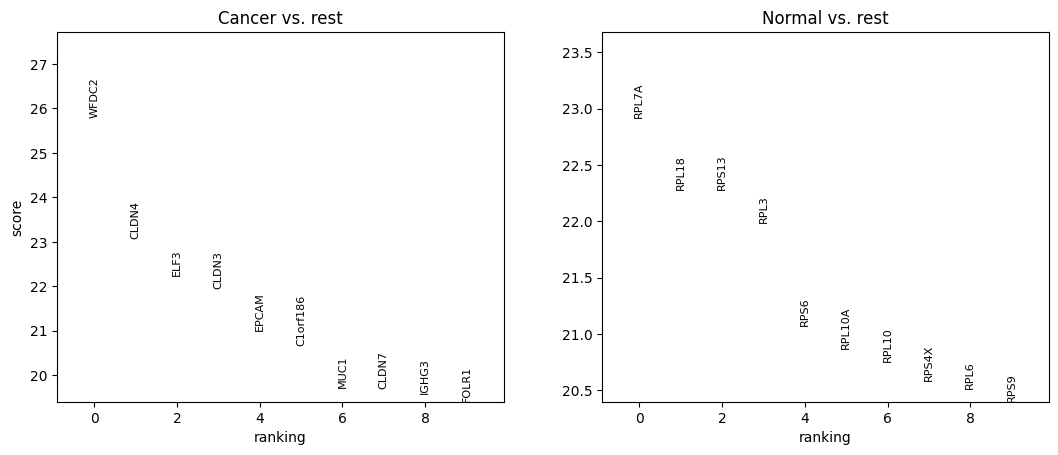

In [48]:
sc.tl.rank_genes_groups(adata_b, groupby='group', method='t-test')
sc.pl.rank_genes_groups(adata_b, n_genes=10, sharey=False)

In [ ]:
import pandas as pd

result = adata_b.uns['rank_genes_groups']
groups = result['names'].dtype.names

scores_df = pd.DataFrame(
    {group: result['scores'][group] for group in groups},
    index=result['names'][groups[0]]
)

print(scores_df.head())

          Cancer     Normal
WFDC2  25.796837  22.921593
CLDN4  23.063297  22.280447
ELF3   22.242014  22.276775
CLDN3  21.940113  21.988043
EPCAM  21.004080  21.073107


In [50]:
markers = ['WFDC2', 'CLDN4', 'ELF3', "CLDN3", 'RPL7A', 'RPL18', 'RPS13', 'RPL3']

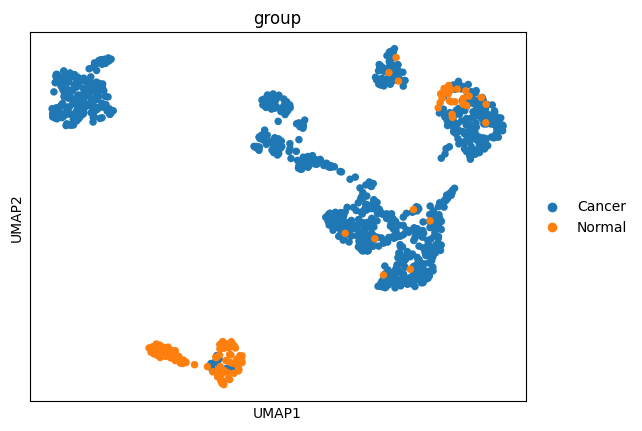

In [51]:
sc.pl.umap(adata_b, color= 'group', cmap='turbo')

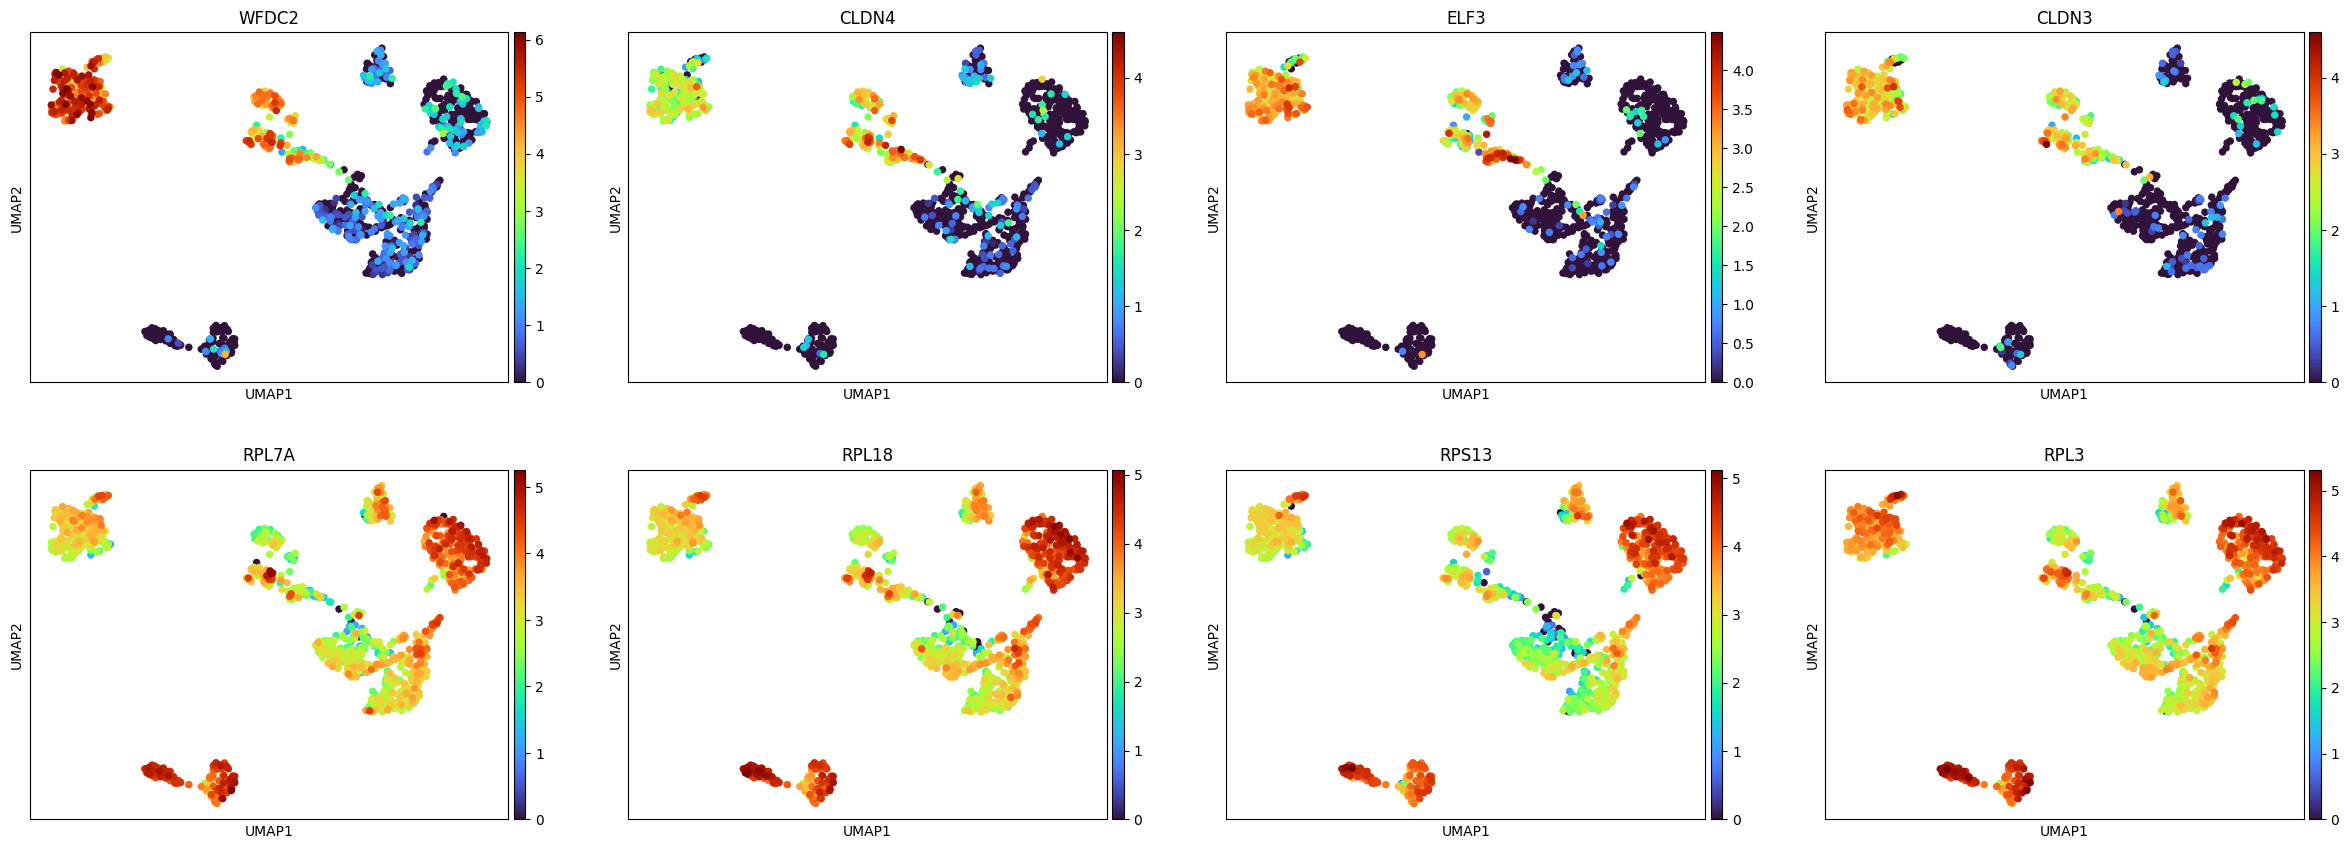

In [52]:
sc.pl.umap(adata_b, color= markers, cmap='turbo')